# Лаговые переменные
Лаговые переменная - это переменная, значение которой мы берем не за текущий, а за отстоящий от него на определенное расстояние предыдущий момент времени.

Т.е. это переменные, взятые с запаздыванием во времени.

**Лаг** - величина интервала запаздывания 

Варианты записи:
+ `lag 10`
+ `lag = 10`
+ это эквивалетно **t-10**

+ `.shift()` - метод для создания лагов
+ `periods` - параметр, с помощью которого указываем **порядок лага** (количество периодов - моментов, на которое значение должно остоять от текущего)

Пример:

`data['Lag3'] = data['sales'].shift(periods=3)`

или
`data['Lag3'] = data['sales'].shift(3)`


In [1]:
import numpy as np
import pandas as pd
import polars as pl
import bottleneck as bn

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt

# настройка визуализации
%config InlineBackend.figure_format = 'retina'

# импорт необходимых классов и функций
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

In [2]:
file = 'Data/example.csv'
data = pd.read_csv(file,
                  sep='\t',
                  index_col=['date'],
                  parse_dates=['date'],
                  date_parser=lambda col: pd.to_datetime(col,
                                                        format='%d.%m.%Y'))
data.index.name = None
data.head()

,sales
2018-01-09,2400
2018-01-10,2800
2018-01-11,2500
2018-01-12,2890
2018-01-13,2610


Пусть у нас есть данные продаж за 12 дней. Создадим лаги с запаздыванием на
+ 3, 4, 5, 6, 12 и 13 дней

In [3]:
lags = [3, 4, 5, 6, 12, 13]
for lag in lags:
    data[f'Lag{lag}'] = data['sales'].shift(lag)
    
data

,sales,Lag3,Lag4,Lag5,Lag6,Lag12,Lag13
2018-01-09,2400,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-10,2800,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-11,2500,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-12,2890,2400.0,NaN,NaN,NaN,NaN,NaN
2018-01-13,2610,2800.0,2400.0,NaN,NaN,NaN,NaN
2018-01-14,2500,2500.0,2800.0,2400.0,NaN,NaN,NaN
2018-01-15,2750,2890.0,2500.0,2800.0,2400.0,NaN,NaN
2018-01-16,2700,2610.0,2890.0,2500.0,2800.0,NaN,NaN
2018-01-17,2250,2500.0,2610.0,2890.0,2500.0,NaN,NaN
2018-01-18,2350,2750.0,2500.0,2610.0,2890.0,NaN,NaN


+ Если порядок лага равен или превышает длину набора данных - тогда получаем столбец из одних пропусков.
+ Чем больше порядок лагов, тем меньше наблюдений используется при его вычислении

Теперь создадим лаги после разделения на обучающую и тестовую выборку:
+ сначала удалим Lag12 и Lag13
+ разобьем наш набор данных так, чтобы в тестовую выборку попали 4 последних наблюдения

Допустим, мы будем прогнозировать продажи на 4 дня вперед:
+ горизонт прогнозирования - 4 дня

In [4]:
data.drop(['Lag12', 'Lag13'], axis=1, inplace=True)

In [5]:
data.head()

,sales,Lag3,Lag4,Lag5,Lag6
2018-01-09,2400,NaN,NaN,NaN,NaN
2018-01-10,2800,NaN,NaN,NaN,NaN
2018-01-11,2500,NaN,NaN,NaN,NaN
2018-01-12,2890,2400.0,NaN,NaN,NaN
2018-01-13,2610,2800.0,2400.0,NaN,NaN


In [6]:
# задаем горизонт
HORIZON = 4

# разбиваем на обучающую и тестовую выборки
train, test = data[0:len(data)-HORIZON], data[len(data)-HORIZON:]
train

,sales,Lag3,Lag4,Lag5,Lag6
2018-01-09,2400,NaN,NaN,NaN,NaN
2018-01-10,2800,NaN,NaN,NaN,NaN
2018-01-11,2500,NaN,NaN,NaN,NaN
2018-01-12,2890,2400.0,NaN,NaN,NaN
2018-01-13,2610,2800.0,2400.0,NaN,NaN
2018-01-14,2500,2500.0,2800.0,2400.0,NaN
2018-01-15,2750,2890.0,2500.0,2800.0,2400.0
2018-01-16,2700,2610.0,2890.0,2500.0,2800.0


In [7]:
test

,sales,Lag3,Lag4,Lag5,Lag6
2018-01-17,2250,2500.0,2610.0,2890.0,2500.0
2018-01-18,2350,2750.0,2500.0,2610.0,2890.0
2018-01-19,2550,2700.0,2750.0,2500.0,2610.0
2018-01-20,3000,2250.0,2700.0,2750.0,2500.0


**Обрати внимание:**
+ чем выше порядок лага - тем более ранние наблюдения обучающей выборки попадают в тестовую выборку

**Обрати внимание**
Не все лаги в тесте используют наблюдения обучающего набора: 
+ лаг 3 "залез" в тест, что является **подсматриванием в будущее**, которая нам не известно (обведено красным овалом)

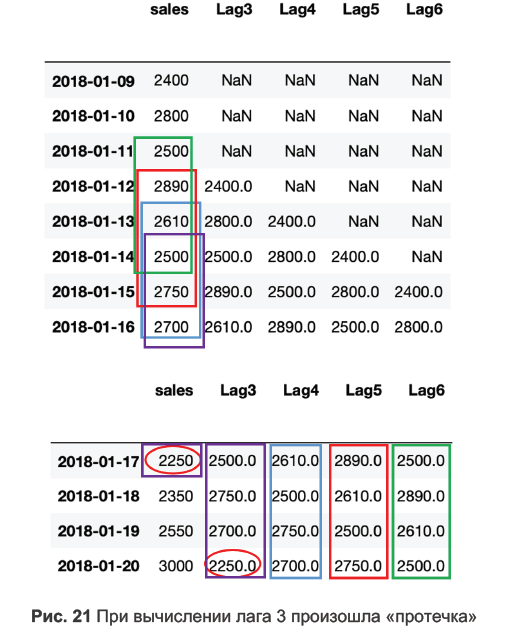

**ВАЖНО**
+ Лаговые переменные необходимо создавать так, чтобы они **не проникали в тестовый набор**

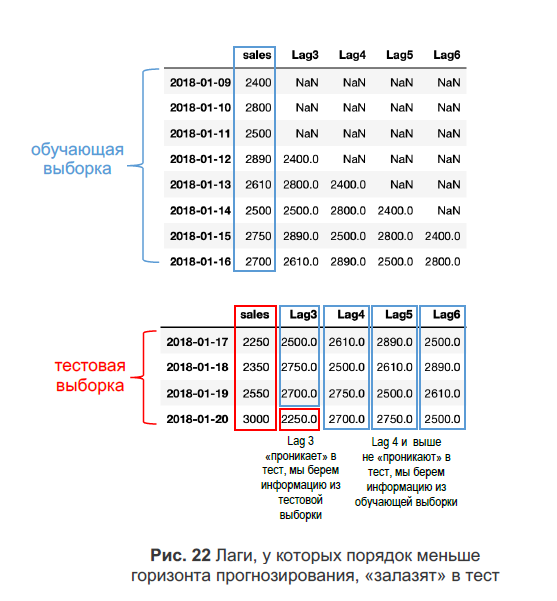

Лаги вида $\displaystyle L_{t-k}$ лучше создавать так, чтобы:
+ $k$ был равен или превышал горизонт прогнозирования
+ иначе в тестовом наборе будем иметь NaN - когда лаг залезет в тест

### Напишем функцию загрузки 
+ загружаем данные
+ читаем столбец с датами как индекс
+ выполняем парсинг дат

In [8]:
def load_data():
    data = pd.read_csv('Data/example.csv', 
                      sep='\t',
                      index_col=['date'],
                       parse_dates=['date'],
                      date_parser=lambda col: pd.to_datetime(col,
                                                           format='%d.%m.%Y'))
    # удаляем имя индекса
    data.index.name = None
    return data

## Для избежания протечек при вычислении лагов применяют два способа:
+ Значение зависимой переменной в наблюдениях исходного набора, которые будут соотстветствовать будущей тестовой выборке (новому набору данных) заменяют значениями NaN
+ берем обучающую выборку и удлиняем ее на длину горизонта прогнозирования: 
    + зависимая переменная в наблюдениях, соответствующая новым временным меткам (т.е. тестовой выборке/наборе новых данных) получает значения NaN

### Первый способ избежания протечек:
+ значения в наблюдениях, которые будут приходится на тестовую выборку (последние 4 наблюдения исходного набора) заменяем на значения NaN
+ Затем формируем лаги порядка 1, 2, 3, 4, 5

In [9]:
data.head()

,sales,Lag3,Lag4,Lag5,Lag6
2018-01-09,2400,NaN,NaN,NaN,NaN
2018-01-10,2800,NaN,NaN,NaN,NaN
2018-01-11,2500,NaN,NaN,NaN,NaN
2018-01-12,2890,2400.0,NaN,NaN,NaN
2018-01-13,2610,2800.0,2400.0,NaN,NaN


In [10]:
data.tail()

,sales,Lag3,Lag4,Lag5,Lag6
2018-01-16,2700,2610.0,2890.0,2500.0,2800.0
2018-01-17,2250,2500.0,2610.0,2890.0,2500.0
2018-01-18,2350,2750.0,2500.0,2610.0,2890.0
2018-01-19,2550,2700.0,2750.0,2500.0,2610.0
2018-01-20,3000,2250.0,2700.0,2750.0,2500.0


In [11]:
HORIZON = 4
data['sales'].iloc[-HORIZON:]

2018-01-17    2250
2018-01-18    2350
2018-01-19    2550
2018-01-20    3000
Name: sales, dtype: int64

In [12]:
# заменяем последние 4 наблюдения на NaN
data['sales'].iloc[-HORIZON:] = np.NaN

C:\Users\User\AppData\Local\Temp\ipykernel_19948\1987524369.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sales'].iloc[-HORIZON:] = np.NaN


Создаем лаги:
+ лаги меньше горизонта прогнозирования получат пропуски в наблюдениях, приходящихся на тест
+ чем меньше порядок лага горизонта - тем больше пропусков в тесте

In [13]:
lags = [1, 2, 3, 4, 5]
for lag in lags:
    data[f'Lag{lag}'] = data['sales'].shift(lag)
print('Тестовая выборка')
data

Тестовая выборка


,sales,Lag3,Lag4,Lag5,Lag6,Lag1,Lag2
2018-01-09,2400.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-10,2800.0,NaN,NaN,NaN,NaN,2400.0,NaN
2018-01-11,2500.0,NaN,NaN,NaN,NaN,2800.0,2400.0
2018-01-12,2890.0,2400.0,NaN,NaN,NaN,2500.0,2800.0
2018-01-13,2610.0,2800.0,2400.0,NaN,NaN,2890.0,2500.0
2018-01-14,2500.0,2500.0,2800.0,2400.0,NaN,2610.0,2890.0
2018-01-15,2750.0,2890.0,2500.0,2800.0,2400.0,2500.0,2610.0
2018-01-16,2700.0,2610.0,2890.0,2500.0,2800.0,2750.0,2500.0
2018-01-17,NaN,2500.0,2610.0,2890.0,2500.0,2700.0,2750.0
2018-01-18,NaN,2750.0,2500.0,2610.0,2890.0,NaN,2700.0


Видим что лаги:
+ у который порядок меньше горизонта прогнозирования - "залезают" в тестовую выборку и получают пропуски в наблюдениях, приходящихся на тестовую выборку
+ чем больше горизонт прогнозирования превышает порядок лага - тем больше пропусков будет в тестовой выборке

**Так срабатывает защита от протечек**

### Второй способ защиты от протечек
+ удлиняем обучающую выборку на длину горизонта прогнозирования
+ зависимую переменную при новых временных метках = NaN

Обучающая выборка - первые 8 наблюдений

In [14]:
data = load_data()
train = data.iloc[:-HORIZON]
train

,sales
2018-01-09,2400
2018-01-10,2800
2018-01-11,2500
2018-01-12,2890
2018-01-13,2610
2018-01-14,2500
2018-01-15,2750
2018-01-16,2700


Напишем функцию, которая:
+ удлиняет обучающую выборку на длину горизонта прогнозирования
+ присваивает зависимой переменной при новых метках - NaN

In [15]:
def calculate_lags(train, target, horizon, lags_range, 
                  freq='D', aggregate=False):
    """
    Создает лаги в обучающей и тестовой выборках.
    
    Параметры
    -----------
    train:
        Обучающий набор
    target:
        Название завимисой переменной
    horizon:
        Горизонт прогнозирования
    lags_range:
        Диапазон значений порядка лагов
    freq: str, значение по умолчанию `D`
        Частота временного ряда
    aggregate: bool, значение по умолчанию False
        Вычисляет аггрегированный лаг
    """

    
    if min(lags_range) < horizon:
        warnings.warn(f"\nКоличество периодов для лагов нужно задавать\n"
                     f"равным или больше горизонта прогнозирования")
        
    if pd.__version__ >= '1.4':
        # создаем метки времени для горизонта
        future_dates = pd.date_range(start=train.index[-1],
                                     periods=horizon + 1,
                                     freq=freq,
                                     inclusive='right')
    else:
        # создаем метки времени для горизонта
        future_dates = pd.date_range(start=train.index[-1],
                                    periods=horizon + 1,
                                    freq=freq,
                                    closed='right')
    # формирукм новый удлиненный индекс
    new_index = train.index.append(future_dates)
    
    # выполняем переиндексацию
    new_df = train.reindex(new_index)

    # создаем лаги
    for i in lags_range:
        new_df[f'Lag_{i}'] = new_df[target].shift(i)
    

    if aggregate and min(lags_range) >= horizon:
        # вычисляем агрегированный лаг
        new_df['Agg_Lag'] = new_df[new_df.filter(
            regex='Lag').columns].mean(axis=1)

        
    train = new_df.iloc[:-horizon]
    test = new_df.iloc[-horizon:]
    return train, test

**Разбор функции `calculate_lags`**

In [16]:
train

,sales
2018-01-09,2400
2018-01-10,2800
2018-01-11,2500
2018-01-12,2890
2018-01-13,2610
2018-01-14,2500
2018-01-15,2750
2018-01-16,2700


In [17]:
horizon = 4
freq = 'D'
future_dates = pd.date_range(start=train.index[-1],
                                     periods=horizon + 1,
                                     freq=freq,
                                     inclusive='right')
future_dates

DatetimeIndex(['2018-01-17', '2018-01-18', '2018-01-19', '2018-01-20'], dtype='datetime64[ns]', freq='D')

In [18]:
new_index = train.index.append(future_dates)
new_index

DatetimeIndex(['2018-01-09', '2018-01-10', '2018-01-11', '2018-01-12',
               '2018-01-13', '2018-01-14', '2018-01-15', '2018-01-16',
               '2018-01-17', '2018-01-18', '2018-01-19', '2018-01-20'],
              dtype='datetime64[ns]', freq=None)

In [19]:
new_df = train.reindex(new_index)
new_df

,sales
2018-01-09,2400.0
2018-01-10,2800.0
2018-01-11,2500.0
2018-01-12,2890.0
2018-01-13,2610.0
2018-01-14,2500.0
2018-01-15,2750.0
2018-01-16,2700.0
2018-01-17,NaN
2018-01-18,NaN


In [20]:
for i in [1,2,3,4,5]:
    new_df[f'Lag_{i}'] = new_df['sales'].shift(i)
new_df

,sales,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5
2018-01-09,2400.0,NaN,NaN,NaN,NaN,NaN
2018-01-10,2800.0,2400.0,NaN,NaN,NaN,NaN
2018-01-11,2500.0,2800.0,2400.0,NaN,NaN,NaN
2018-01-12,2890.0,2500.0,2800.0,2400.0,NaN,NaN
2018-01-13,2610.0,2890.0,2500.0,2800.0,2400.0,NaN
2018-01-14,2500.0,2610.0,2890.0,2500.0,2800.0,2400.0
2018-01-15,2750.0,2500.0,2610.0,2890.0,2500.0,2800.0
2018-01-16,2700.0,2750.0,2500.0,2610.0,2890.0,2500.0
2018-01-17,NaN,2700.0,2750.0,2500.0,2610.0,2890.0
2018-01-18,NaN,NaN,2700.0,2750.0,2500.0,2610.0


In [21]:
new_df[new_df.filter(regex='Lag').columns]

,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5
2018-01-09,NaN,NaN,NaN,NaN,NaN
2018-01-10,2400.0,NaN,NaN,NaN,NaN
2018-01-11,2800.0,2400.0,NaN,NaN,NaN
2018-01-12,2500.0,2800.0,2400.0,NaN,NaN
2018-01-13,2890.0,2500.0,2800.0,2400.0,NaN
2018-01-14,2610.0,2890.0,2500.0,2800.0,2400.0
2018-01-15,2500.0,2610.0,2890.0,2500.0,2800.0
2018-01-16,2750.0,2500.0,2610.0,2890.0,2500.0
2018-01-17,2700.0,2750.0,2500.0,2610.0,2890.0
2018-01-18,NaN,2700.0,2750.0,2500.0,2610.0


In [22]:
new_df['Agg_Lag'] = new_df[new_df.filter(regex='Lag').columns].mean(axis=1)
new_df

,sales,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Agg_Lag
2018-01-09,2400.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-10,2800.0,2400.0,NaN,NaN,NaN,NaN,2400.000000
2018-01-11,2500.0,2800.0,2400.0,NaN,NaN,NaN,2600.000000
2018-01-12,2890.0,2500.0,2800.0,2400.0,NaN,NaN,2566.666667
2018-01-13,2610.0,2890.0,2500.0,2800.0,2400.0,NaN,2647.500000
2018-01-14,2500.0,2610.0,2890.0,2500.0,2800.0,2400.0,2640.000000
2018-01-15,2750.0,2500.0,2610.0,2890.0,2500.0,2800.0,2660.000000
2018-01-16,2700.0,2750.0,2500.0,2610.0,2890.0,2500.0,2650.000000
2018-01-17,NaN,2700.0,2750.0,2500.0,2610.0,2890.0,2690.000000
2018-01-18,NaN,NaN,2700.0,2750.0,2500.0,2610.0,2640.000000


In [23]:
train = new_df.iloc[:-horizon]
test = new_df.iloc[-horizon:]

In [24]:
train

,sales,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Agg_Lag
2018-01-09,2400.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-10,2800.0,2400.0,NaN,NaN,NaN,NaN,2400.000000
2018-01-11,2500.0,2800.0,2400.0,NaN,NaN,NaN,2600.000000
2018-01-12,2890.0,2500.0,2800.0,2400.0,NaN,NaN,2566.666667
2018-01-13,2610.0,2890.0,2500.0,2800.0,2400.0,NaN,2647.500000
2018-01-14,2500.0,2610.0,2890.0,2500.0,2800.0,2400.0,2640.000000
2018-01-15,2750.0,2500.0,2610.0,2890.0,2500.0,2800.0,2660.000000
2018-01-16,2700.0,2750.0,2500.0,2610.0,2890.0,2500.0,2650.000000


In [25]:
test

,sales,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Agg_Lag
2018-01-17,NaN,2700.0,2750.0,2500.0,2610.0,2890.0,2690.0
2018-01-18,NaN,NaN,2700.0,2750.0,2500.0,2610.0,2640.0
2018-01-19,NaN,NaN,NaN,2700.0,2750.0,2500.0,2650.0
2018-01-20,NaN,NaN,NaN,NaN,2700.0,2750.0,2725.0


**Применим функцию и создадим лаги порядка 3, 4, 5**

In [28]:
data = load_data()
train = data.iloc[:-HORIZON]
tr, tst = calculate_lags(train, target='sales',
                        horizon=4, lags_range=range(3,6),
                        freq='D', aggregate=False)

C:\Users\User\AppData\Local\Temp\ipykernel_19948\1679622827.py:24: UserWarning: 
Количество периодов для лагов нужно задавать
равным или больше горизонта прогнозирования
  warnings.warn(f"\nКоличество периодов для лагов нужно задавать\n"


In [29]:
# смотрим лаги в обучающей выборке
tr

,sales,Lag_3,Lag_4,Lag_5
2018-01-09,2400.0,NaN,NaN,NaN
2018-01-10,2800.0,NaN,NaN,NaN
2018-01-11,2500.0,NaN,NaN,NaN
2018-01-12,2890.0,2400.0,NaN,NaN
2018-01-13,2610.0,2800.0,2400.0,NaN
2018-01-14,2500.0,2500.0,2800.0,2400.0
2018-01-15,2750.0,2890.0,2500.0,2800.0
2018-01-16,2700.0,2610.0,2890.0,2500.0


In [30]:
# смотрим лаги в тесте выборке
tst

,sales,Lag_3,Lag_4,Lag_5
2018-01-17,NaN,2500.0,2610.0,2890.0
2018-01-18,NaN,2750.0,2500.0,2610.0
2018-01-19,NaN,2700.0,2750.0,2500.0
2018-01-20,NaN,NaN,2700.0,2750.0


## 

Видим, что `Lag_3` получает пропуск, когда пытается использовать информацию тестовой выборки

**Про агрегированные лаги**
+ можно взять простое среднее лагов: $(L_{t-7}+L_{t-14}+L_{t-21})/3$
+ можно усреднять лаги с использованием различных весов
+ можно брать медиану, стандартное отклонение значений лагов

In [31]:
# создаем лаги и агрегированный лаг
# для обучающей и тестовой выборок
data = load_data()
train = data.iloc[:-HORIZON]

tr, tst = calculate_lags(train, target='sales',
                        horizon=4, lags_range=range(4,6),
                        freq='D', aggregate=True)

In [32]:
tr

,sales,Lag_4,Lag_5,Agg_Lag
2018-01-09,2400.0,NaN,NaN,NaN
2018-01-10,2800.0,NaN,NaN,NaN
2018-01-11,2500.0,NaN,NaN,NaN
2018-01-12,2890.0,NaN,NaN,NaN
2018-01-13,2610.0,2400.0,NaN,2400.0
2018-01-14,2500.0,2800.0,2400.0,2600.0
2018-01-15,2750.0,2500.0,2800.0,2650.0
2018-01-16,2700.0,2890.0,2500.0,2695.0


In [33]:
tst

,sales,Lag_4,Lag_5,Agg_Lag
2018-01-17,NaN,2610.0,2890.0,2750.0
2018-01-18,NaN,2500.0,2610.0,2555.0
2018-01-19,NaN,2750.0,2500.0,2625.0
2018-01-20,NaN,2700.0,2750.0,2725.0


**Функция `weighted_average_lag`:**
+ вычисляет агрегированный лаг на основе взвешенного среднего лага

In [34]:
def weighted_average_lag(data, lags, lags_weights,
                        intermediate_results):
    df = data.copy()
    for cnt, i in enumerate(df[lags].columns):
        df[i] = df[i] * lags_weights[cnt]
    if intermediate_results:
        print(df)
    data['Weighted_Average_Lag'] = df[lags].mean(axis=1)
    return data     

In [35]:
for cnt, i in enumerate(tr.columns):
    print(cnt, i)

0 sales
1 Lag_4
2 Lag_5
3 Agg_Lag


In [36]:
# вычисляем агрегированный лаг на основе взвешенного среднего лагов
weighted_average_lag(tr, lags=['Lag_4', 'Lag_5'],
                    lags_weights=[1,2],
                    intermediate_results=True)


             sales   Lag_4   Lag_5  Agg_Lag
2018-01-09  2400.0     NaN     NaN      NaN
2018-01-10  2800.0     NaN     NaN      NaN
2018-01-11  2500.0     NaN     NaN      NaN
2018-01-12  2890.0     NaN     NaN      NaN
2018-01-13  2610.0  2400.0     NaN   2400.0
2018-01-14  2500.0  2800.0  4800.0   2600.0
2018-01-15  2750.0  2500.0  5600.0   2650.0
2018-01-16  2700.0  2890.0  5000.0   2695.0


,sales,Lag_4,Lag_5,Agg_Lag,Weighted_Average_Lag
2018-01-09,2400.0,NaN,NaN,NaN,NaN
2018-01-10,2800.0,NaN,NaN,NaN,NaN
2018-01-11,2500.0,NaN,NaN,NaN,NaN
2018-01-12,2890.0,NaN,NaN,NaN,NaN
2018-01-13,2610.0,2400.0,NaN,2400.0,2400.0
2018-01-14,2500.0,2800.0,2400.0,2600.0,3800.0
2018-01-15,2750.0,2500.0,2800.0,2650.0,4050.0
2018-01-16,2700.0,2890.0,2500.0,2695.0,3945.0


## Вычисление лагов в `Polars`
### Реализация первого способа защиты от протечек

In [37]:
# преобразуем датафрейм pandas в датафрейм Polars
data = pd.DataFrame(new_df['sales'].copy())
display(data)
polars_data = pl.DataFrame(data)
polars_data

,sales
2018-01-09,2400.0
2018-01-10,2800.0
2018-01-11,2500.0
2018-01-12,2890.0
2018-01-13,2610.0
2018-01-14,2500.0
2018-01-15,2750.0
2018-01-16,2700.0
2018-01-17,NaN
2018-01-18,NaN


sales
f64
2400.0
2800.0
2500.0
2890.0
2610.0
2500.0
2750.0
2700.0
null


Особенности `Polars`:
+ нет индекса
+ пропускам соответствует значения **null**

In [38]:
# создаем лаги в Polars
polars_data = polars_data.with_columns([pl.col('sales').shift(1).alias('Lag_1'),
                                       pl.col('sales').shift(2).alias('Lag_2'),
                                       pl.col('sales').shift(3).alias('Lag_3'),
                                       pl.col('sales').shift(4).alias('Lag_4'),
                                       pl.col('sales').shift(5).alias('Lag_5')])
polars_data

sales,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5
f64,f64,f64,f64,f64,f64
2400.0,null,null,null,null,null
2800.0,2400.0,null,null,null,null
2500.0,2800.0,2400.0,null,null,null
2890.0,2500.0,2800.0,2400.0,null,null
2610.0,2890.0,2500.0,2800.0,2400.0,null
2500.0,2610.0,2890.0,2500.0,2800.0,2400.0
2750.0,2500.0,2610.0,2890.0,2500.0,2800.0
2700.0,2750.0,2500.0,2610.0,2890.0,2500.0
null,2700.0,2750.0,2500.0,2610.0,2890.0


Видим, что :
+ лаги, у которых порядок меньше горизонта прогнозирования **залезают** в тестовую выборку и получают пропуски в наблюдениях
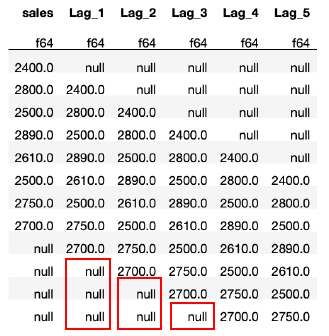

Для удобства можем добавить в Polars даты.

Возьмем даты из исходного датафрейма pandas

In [39]:
# создаем копию
data2 = data.copy()
display('Создаем копию', data2)

# на основе индекса создаем переменную с датами
data2['date'] = data2.index
display('на основе индекса создаем переменную с датами', data2)

# столбец с датами ставим первым
first_column = data2.pop('date')
data2.insert(0, 'date', first_column)
display('столбец с датами ставим первым', data2)


# преобразовываем датафрейм pandas  в датафрейм Polars
polars_data = pl.DataFrame(data2)
display("преобразовываем датафрейм pandas  в датафрейм Polars", polars_data)

# присваиваем столбцу с датами тип Date
polars_data = polars_data.with_columns(pl.col('date').cast(pl.Date))
display("Присваиваем столбцу с датами тип Date", polars_data)

'Создаем копию'

,sales
2018-01-09,2400.0
2018-01-10,2800.0
2018-01-11,2500.0
2018-01-12,2890.0
2018-01-13,2610.0
2018-01-14,2500.0
2018-01-15,2750.0
2018-01-16,2700.0
2018-01-17,NaN
2018-01-18,NaN


'на основе индекса создаем переменную с датами'

,sales,date
2018-01-09,2400.0,2018-01-09
2018-01-10,2800.0,2018-01-10
2018-01-11,2500.0,2018-01-11
2018-01-12,2890.0,2018-01-12
2018-01-13,2610.0,2018-01-13
2018-01-14,2500.0,2018-01-14
2018-01-15,2750.0,2018-01-15
2018-01-16,2700.0,2018-01-16
2018-01-17,NaN,2018-01-17
2018-01-18,NaN,2018-01-18


'столбец с датами ставим первым'

,date,sales
2018-01-09,2018-01-09,2400.0
2018-01-10,2018-01-10,2800.0
2018-01-11,2018-01-11,2500.0
2018-01-12,2018-01-12,2890.0
2018-01-13,2018-01-13,2610.0
2018-01-14,2018-01-14,2500.0
2018-01-15,2018-01-15,2750.0
2018-01-16,2018-01-16,2700.0
2018-01-17,2018-01-17,NaN
2018-01-18,2018-01-18,NaN


'преобразовываем датафрейм pandas  в датафрейм Polars'

date,sales
datetime[ns],f64
2018-01-09 00:00:00,2400.0
2018-01-10 00:00:00,2800.0
2018-01-11 00:00:00,2500.0
2018-01-12 00:00:00,2890.0
2018-01-13 00:00:00,2610.0
2018-01-14 00:00:00,2500.0
2018-01-15 00:00:00,2750.0
2018-01-16 00:00:00,2700.0
2018-01-17 00:00:00,null


'Присваиваем столбцу с датами тип Date'

date,sales
date,f64
2018-01-09,2400.0
2018-01-10,2800.0
2018-01-11,2500.0
2018-01-12,2890.0
2018-01-13,2610.0
2018-01-14,2500.0
2018-01-15,2750.0
2018-01-16,2700.0
2018-01-17,null


In [40]:
# создаем список лагов
lags_lst = list(range(1,6))

# создаем лаги в Polars
for i in lags_lst:
    polars_data = polars_data.with_columns([pl.col('sales').\
                                            shift(i).alias(f'Lag_{i}')])
polars_data  

date,sales,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5
date,f64,f64,f64,f64,f64,f64
2018-01-09,2400.0,null,null,null,null,null
2018-01-10,2800.0,2400.0,null,null,null,null
2018-01-11,2500.0,2800.0,2400.0,null,null,null
2018-01-12,2890.0,2500.0,2800.0,2400.0,null,null
2018-01-13,2610.0,2890.0,2500.0,2800.0,2400.0,null
2018-01-14,2500.0,2610.0,2890.0,2500.0,2800.0,2400.0
2018-01-15,2750.0,2500.0,2610.0,2890.0,2500.0,2800.0
2018-01-16,2700.0,2750.0,2500.0,2610.0,2890.0,2500.0
2018-01-17,null,2700.0,2750.0,2500.0,2610.0,2890.0


### Второй способ защиты от протечек в Polars

In [42]:
# создаем копию
train2 = train.copy()
# на основе индекса создаем переменную с датами
train2['date'] = train2.index
train2

,sales,date
2018-01-09,2400,2018-01-09
2018-01-10,2800,2018-01-10
2018-01-11,2500,2018-01-11
2018-01-12,2890,2018-01-12
2018-01-13,2610,2018-01-13
2018-01-14,2500,2018-01-14
2018-01-15,2750,2018-01-15
2018-01-16,2700,2018-01-16


In [46]:
# столбец с датами ставим первым
first_column = train2.pop('date')
train2.insert(0, 'date', first_column)
train2

,date,sales
2018-01-09,2018-01-09,2400
2018-01-10,2018-01-10,2800
2018-01-11,2018-01-11,2500
2018-01-12,2018-01-12,2890
2018-01-13,2018-01-13,2610
2018-01-14,2018-01-14,2500
2018-01-15,2018-01-15,2750
2018-01-16,2018-01-16,2700


In [48]:
# преобразовываем датафрейм пандас в датафрейм Polars
polars_train_data = pd.DataFrame(train2)
polars_train_data = pl.DataFrame(train2)
polars_train_data

date,sales
datetime[ns],i64
2018-01-09 00:00:00,2400
2018-01-10 00:00:00,2800
2018-01-11 00:00:00,2500
2018-01-12 00:00:00,2890
2018-01-13 00:00:00,2610
2018-01-14 00:00:00,2500
2018-01-15 00:00:00,2750
2018-01-16 00:00:00,2700


In [50]:
# присваиваем столбцу с датами типа Date
polars_train_data = polars_train_data.with_columns(pl.col('date').cast(pl.Date))
polars_train_data

date,sales
date,i64
2018-01-09,2400
2018-01-10,2800
2018-01-11,2500
2018-01-12,2890
2018-01-13,2610
2018-01-14,2500
2018-01-15,2750
2018-01-16,2700


In [75]:
# функция для создания лагов
# в обучающей и тестовой выборках 
def polars_calculate_lags(polars_train,
                         target_column,
                         date_column,
                         horizon,
                         lags_range,
                         aggregate =False):
    """
    Создает лаги в обучающей и тестовой выборках
    
    Параметры
    -------------
    train:
        Обучающий набор
    target_column:
        название переменной с датами
    date_column:
        Название переменнйо с датами
    horizon:
        Горизонт прогнозирования
    lags_range:
        Диапазон значений порядка лагов
    aggregate: bool, значение по умолчанию False
        Вычисляем агрегированный лаг
    
    
    """
    
    # вычисляем длину горизонта
    h = len(horizon)
    
    if min(lags_range) < h:
        warnings.warn(f'\nКоличество периодов для лагов нужно задвать\n'
                      f'равным или больше горизонта прогнозирования')
        
    # удлиняем набор на длину горизонта
    dates = polars_train.select(date_column).to_series()
    steps = pl.Series(date_column, horizon).str.strptime(pl.Date)
    final_dates = dates.append(steps).to_frame()
    polars_df = polars_train.join(final_dates, how='outer', 
                                 on=date_column)
    
    # создаем лаги в Polars
    for i in lags_range:
        polars_df = polars_df.with_columns([
            pl.col(target_column).shift(i).alias(f'Lag_{i}')])
        
    if aggregate and min(lags_range) >=h:
        # вычисляем агрегированный лаг
        polars_df = polars_df.with_columns([polars_df.select(
        pl.col('^Lag_.*$')).mean(axis=1).alias('Agg_Lag')])
        
    train = polars_df[0:len(final_dates) - h]
    test = polars_df[len(final_dates) - h:]
    
    return train, test

In [76]:
# создаем лаги для обучающей и тестовой выборок
polars_train, polars_test = polars_calculate_lags(
                            polars_train_data,
                            'sales',
                            'date',
                            horizon=['2018-01-17', '2018-01-18',
                                    '2018-01-19','2018-01-20'],
                            lags_range=range(3,6))

C:\Users\User\AppData\Local\Temp\ipykernel_19948\1248865699.py:34: UserWarning: 
Количество периодов для лагов нужно задвать
равным или больше горизонта прогнозирования
  warnings.warn(f'\nКоличество периодов для лагов нужно задвать\n'


In [77]:
# смотрим лаги в обучающей выборке
polars_train

date,sales,date_right,Lag_3,Lag_4,Lag_5
date,i64,date,i64,i64,i64
2018-01-09,2400,2018-01-09,null,null,null
2018-01-10,2800,2018-01-10,null,null,null
2018-01-11,2500,2018-01-11,null,null,null
2018-01-12,2890,2018-01-12,2400,null,null
2018-01-13,2610,2018-01-13,2800,2400,null
2018-01-14,2500,2018-01-14,2500,2800,2400
2018-01-15,2750,2018-01-15,2890,2500,2800
2018-01-16,2700,2018-01-16,2610,2890,2500


In [78]:
# смотрим лаги в тестовой выборке
polars_test

date,sales,date_right,Lag_3,Lag_4,Lag_5
date,i64,date,i64,i64,i64
null,null,2018-01-17,2500,2610,2890
null,null,2018-01-18,2750,2500,2610
null,null,2018-01-19,2700,2750,2500
null,null,2018-01-20,null,2700,2750


In [79]:
polars_train, polars_test = polars_calculate_lags(
                            polars_train_data,
                            'sales',
                            'date',
                            horizon=['2018-01-17', '2018-01-18',
                                    '2018-01-19','2018-01-20'],
                            lags_range=range(4,6),
                            aggregate=True)

C:\Users\User\AppData\Local\Temp\ipykernel_19948\1248865699.py:52: DeprecationWarning: The `axis` parameter for `DataFrame.mean` is deprecated. Use `DataFrame.mean_horizontal()` to perform horizontal aggregation.
  pl.col('^Lag_.*$')).mean(axis=1).alias('Agg_Lag')])


In [80]:
polars_train

date,sales,date_right,Lag_4,Lag_5,Agg_Lag
date,i64,date,i64,i64,f64
2018-01-09,2400,2018-01-09,null,null,null
2018-01-10,2800,2018-01-10,null,null,null
2018-01-11,2500,2018-01-11,null,null,null
2018-01-12,2890,2018-01-12,null,null,null
2018-01-13,2610,2018-01-13,2400,null,2400.0
2018-01-14,2500,2018-01-14,2800,2400,2600.0
2018-01-15,2750,2018-01-15,2500,2800,2650.0
2018-01-16,2700,2018-01-16,2890,2500,2695.0


In [81]:
polars_test

date,sales,date_right,Lag_4,Lag_5,Agg_Lag
date,i64,date,i64,i64,f64
null,null,2018-01-17,2610,2890,2750.0
null,null,2018-01-18,2500,2610,2555.0
null,null,2018-01-19,2750,2500,2625.0
null,null,2018-01-20,2700,2750,2725.0
